In [1]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
import warnings 
warnings.filterwarnings('ignore')# I'm sick of all the red.
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% reload_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


array(['ppcor', 'MASS', 'afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans',
       'estimability', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U12')

In [2]:
data = hddm.load_csv('embarc_prt_data_stim_coded.csv') # load the stimulus coded data w/ hddm

## Model 1

Summary: Convergence looks good. I think that this model makes the most sense to use out of all of them (based on lowest DIC & sensible means for z & v. 

In [5]:
stim_coding_model = hddm.HDDMStimCoding(data, include='z', stim_col='stim', split_param='v', depends_on={'v': 'feasibility', 'a': 'feasibility', 'z': 'feasibility'})
stim_coding_model.find_starting_values()
stim_coding_model.sample(10000, burn=1000, dbname='embarc_stim_group_bias.db', db='pickle')

 [-----------------100%-----------------] 10001 of 10000 complete in 5715.5 sec

In [6]:
stim_coding_model.dic_info

{'DIC': -10678.152002396107,
 'deviance': -11726.966627540327,
 'pD': 1048.8146251442195}

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


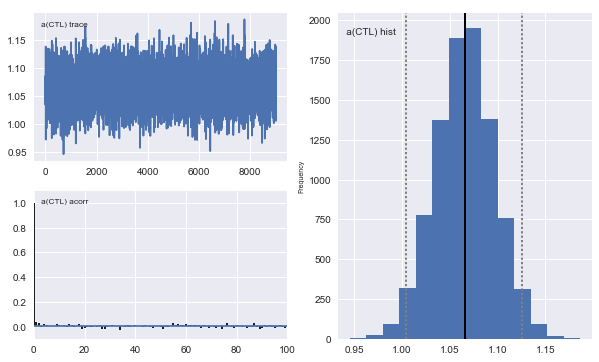

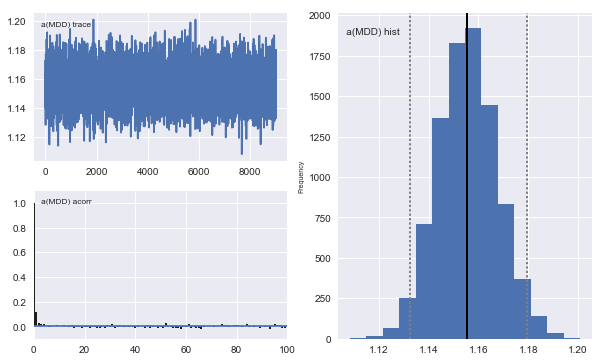

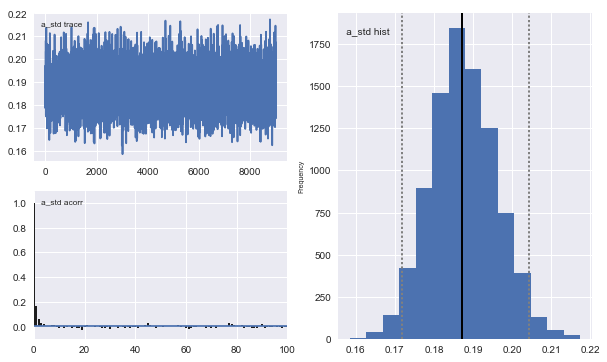

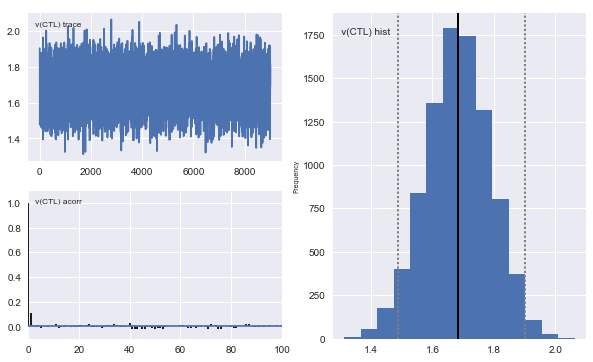

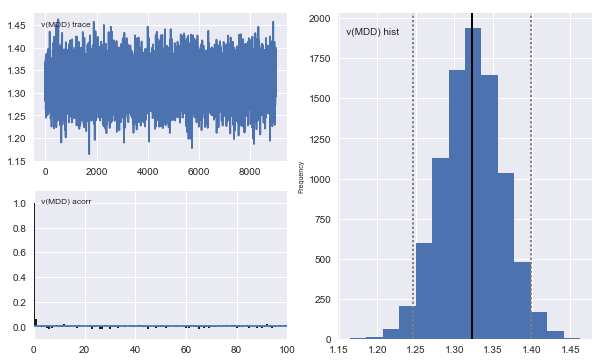

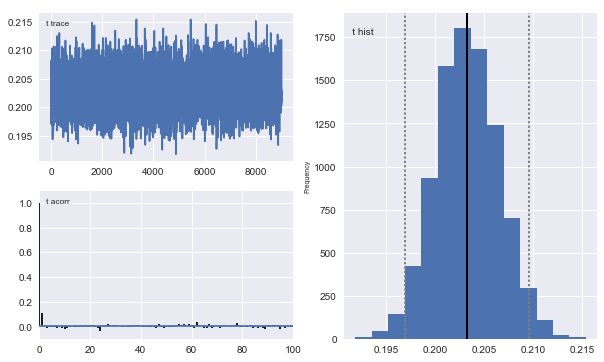

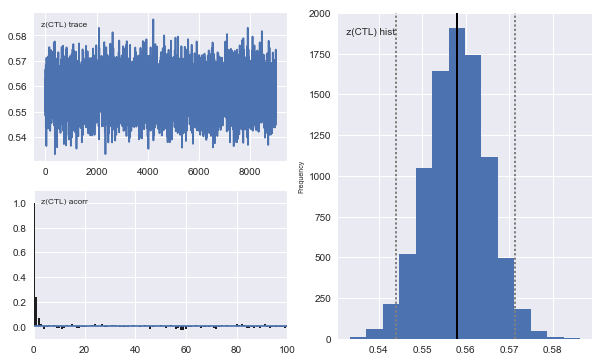

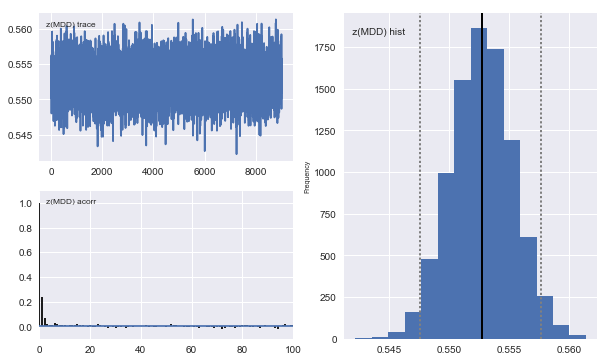

In [7]:
# looks okay to me
stim_coding_model.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

P_z(MDD > CON) =  0.237888888889
P_z(CON > MDD) =  0.762111111111


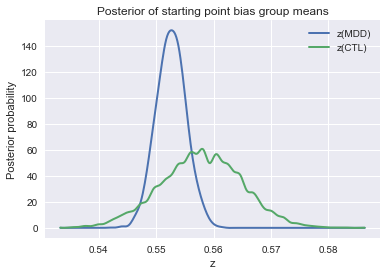

In [40]:
z_MDD, z_CON = stim_coding_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

In [37]:
# This cell + comments isn't relevant now but I'm keeping so I don't forget at later time

# Let's check if the subject data is showing z's that are less than .5...it might be the case that looking at 
# z_trans rather than z directly is the culprit (it was). 

stim_coding_model.gen_stats().tail() # just showing the tail here so it's not annoying, but most of the subs have z's
                                     # of > .05. So the z_trans plot must not be plotting the straight z vals

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
z_subj(MDD).UM0117,0.562798,0.0175814,0.528297,0.550854,0.562784,0.574893,0.596945,0.000190765
z_subj(MDD).UM0118,0.540203,0.0177263,0.505872,0.527963,0.540531,0.552235,0.574547,0.000186493
z_subj(MDD).UM0119,0.580337,0.0175574,0.545979,0.568562,0.580318,0.591867,0.61451,0.000156488
z_subj(MDD).UM0120,0.598154,0.0174462,0.563883,0.586156,0.598482,0.609933,0.631876,0.000205198
z_subj(MDD).UM0121,0.535108,0.0177914,0.50052,0.522989,0.535094,0.547094,0.569726,0.000181153


P_a(MDD > CON) =  0.997555555556
P_a(CON > MDD) =  0.00244444444444


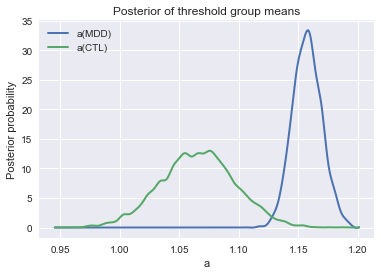

In [9]:
a_MDD, a_CON = stim_coding_model.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_v(MDD > CON) =  0.000444444444444
P_v(CON > MDD) =  0.999555555556


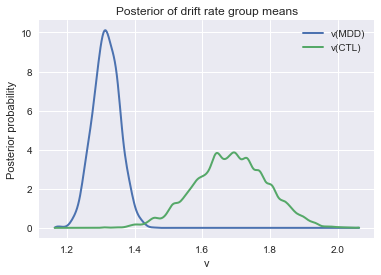

In [10]:
v_MDD, v_CON = stim_coding_model.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

## Model 2

Summary: I think poor convergence makes it not a contender. Also higher DIC than model 1.

In [11]:
reg_model = hddm.HDDM(data, bias=True, include='all', depends_on={'v': 'feasibility', 'a': 'feasibility', 'z': 'feasibility'})
reg_model.find_starting_values()
reg_model.sample(10000, burn=1000, dbname='embarc_stim_group_bias.db', db='pickle')

 [-----------------100%-----------------] 10001 of 10000 complete in 225562.4 sec

In [12]:
reg_model.dic_info

{'DIC': -106.48098554338799,
 'deviance': -974.07872533397892,
 'pD': 867.59773979059094}

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


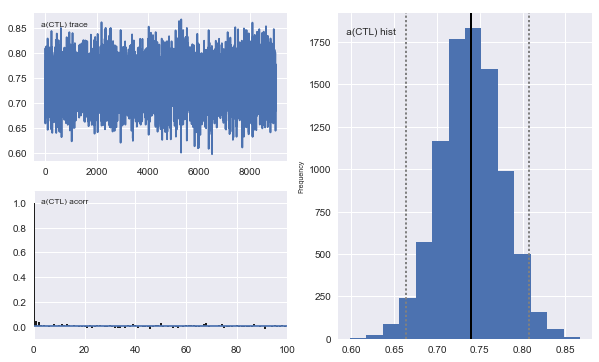

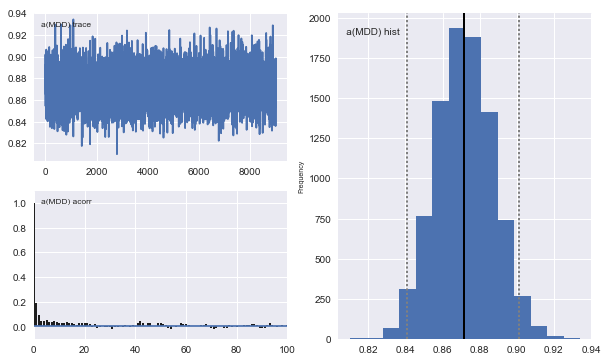

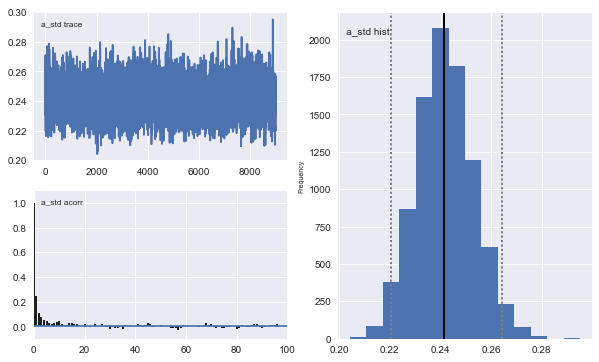

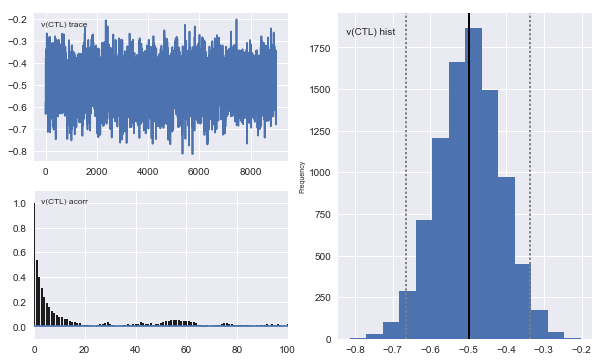

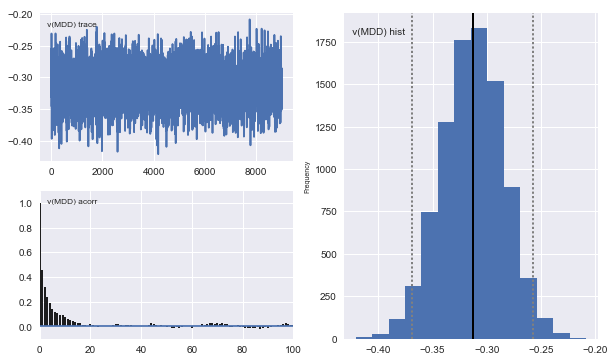

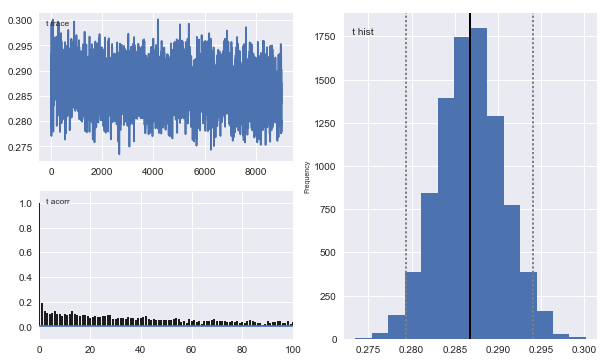

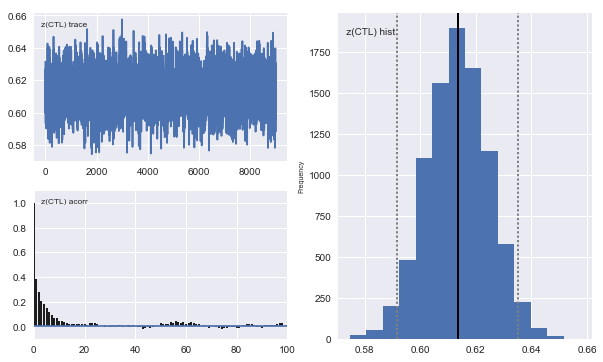

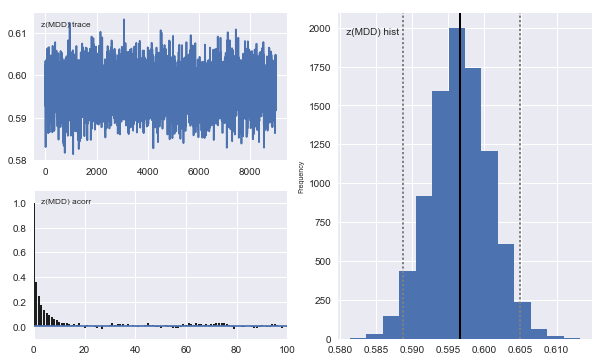

In [13]:
#this looks pretty bad i think
reg_model.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

P_z(MDD > CON) =  0.0803333333333
P_z(CON > MDD) =  0.919666666667


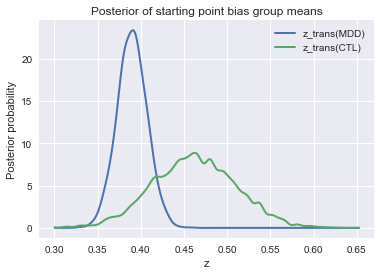

In [14]:
z_MDD, z_CON = reg_model.nodes_db.node[['z_trans(MDD)','z_trans(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.999888888889
P_a(CON > MDD) =  0.000111111111111


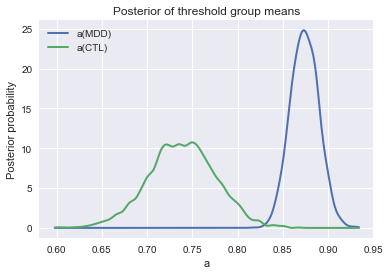

In [15]:
a_MDD, a_CON = reg_model.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_v(MDD > CON) =  0.983444444444
P_v(CON > MDD) =  0.0165555555556


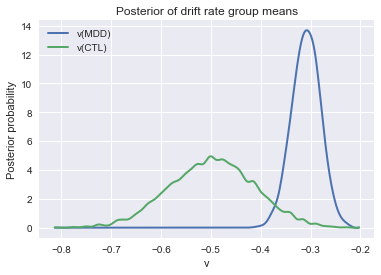

In [16]:
# this doesn't look right, it's fine that it's negative (more 0 responses than 1) but I don't think it should be so low. 
v_MDD, v_CON = reg_model.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

## Model 3

Summary: Convergence seems fine but DIC is much higher than model 1. See notes on model 4 for more reasons why this model prob isn't best. 

In [17]:
stim_coding_model_nosplit = hddm.HDDMStimCoding(data, stim_col='stim', depends_on={'v': 'feasibility', 'a': 'feasibility', 'z': 'feasibility'}, include=('z'))
stim_coding_model_nosplit.find_starting_values()
stim_coding_model_nosplit.sample(10000, burn=1000)

Setting model to be non-informative
Adding z to includes.
 [-----------------100%-----------------] 10001 of 10000 complete in 13424.5 sec

In [18]:
stim_coding_model_nosplit.dic_info

{'DIC': 10352.521961160486,
 'deviance': 9368.6304397262757,
 'pD': 983.89152143421052}

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


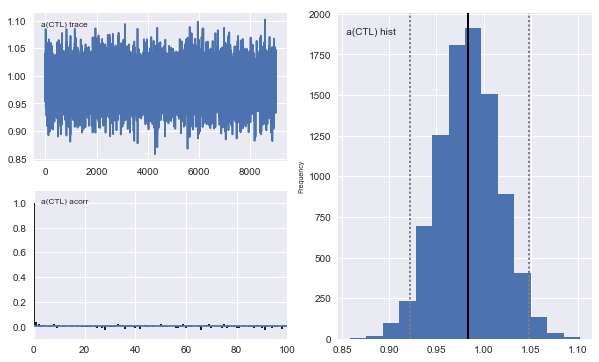

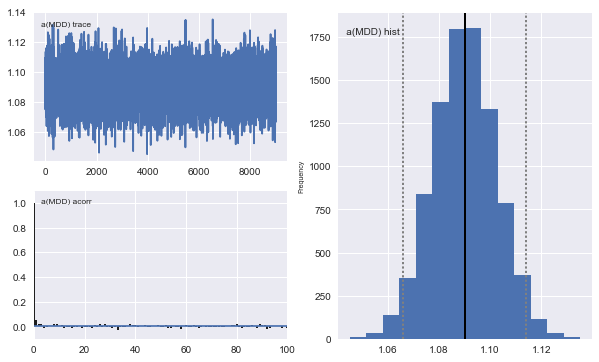

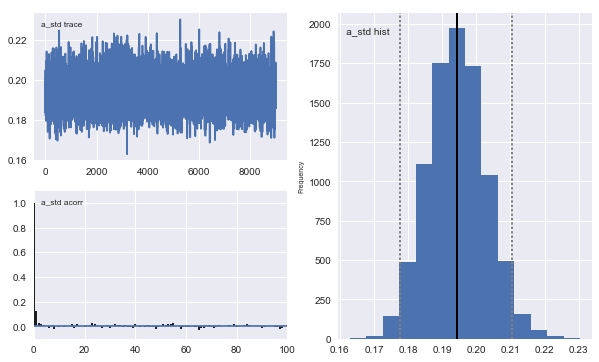

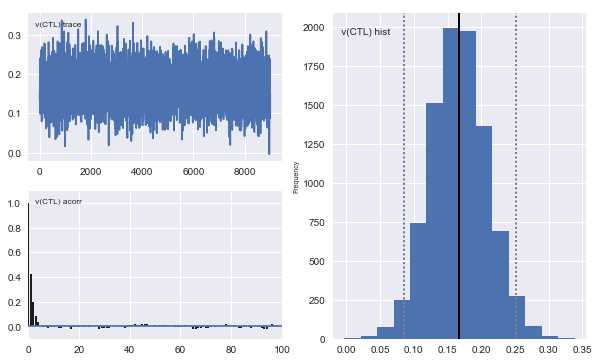

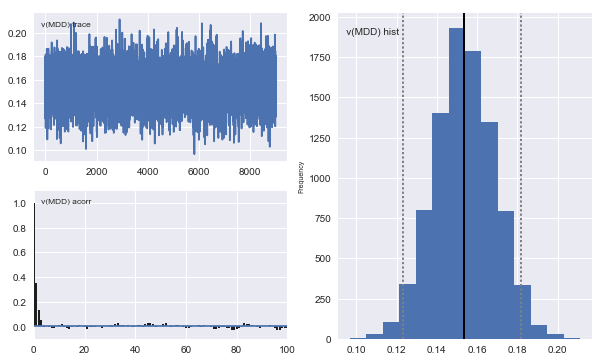

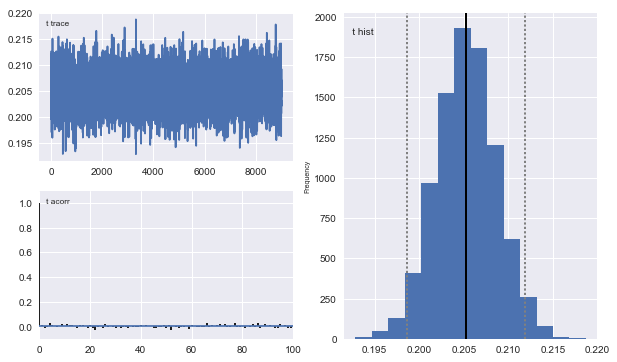

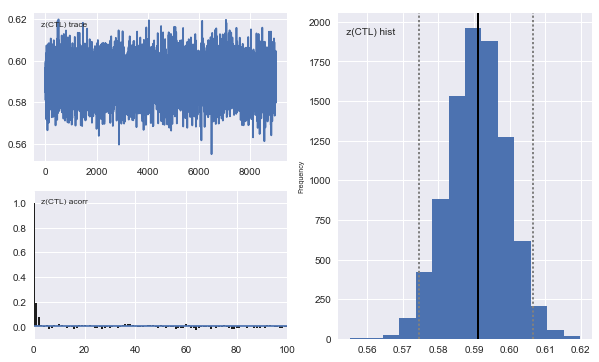

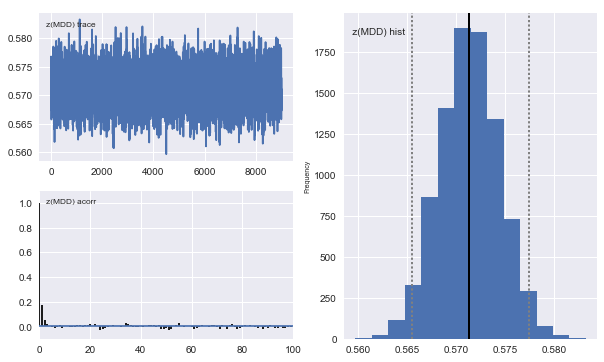

In [19]:
stim_coding_model_nosplit.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

P_z(MDD > CON) =  0.0124444444444
P_z(CON > MDD) =  0.987555555556


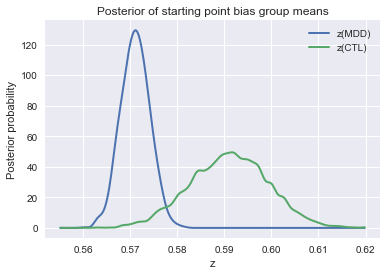

In [42]:
z_MDD, z_CON = stim_coding_model_nosplit.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.999
P_a(CON > MDD) =  0.001


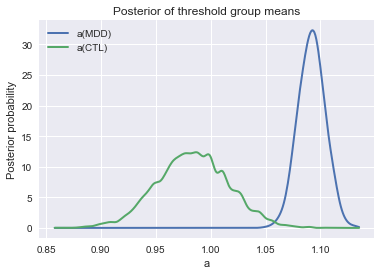

In [21]:
a_MDD, a_CON = stim_coding_model_nosplit.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_v(MDD > CON) =  0.384
P_v(CON > MDD) =  0.616


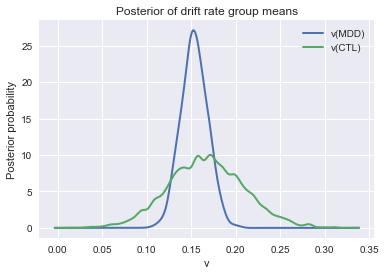

In [22]:
v_MDD, v_CON = stim_coding_model_nosplit.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

## Model 4  
"However, if you do stimulus-coding make sure to have drift-rate depend on stimulus-type (which I don't see in your code above). Otherwise you'll end up with drift-rate close to 0 even though your accuracy can be very high. That's what might be causing the bad fit."  
  
TW wrote the above comment in response to someone in the hdd-users group, so here I had v depend on feasibility AND stim. I think that it's actually not needed if we split on v though (as we do in model 1). In model 3 we split on z (the default) and we do see the v very close to zero like TW suggested. I think it's best not to use this model and stick with the first model because 1) convergence for z doesn't look great here, 2) and the z means should both be above .05, and 3) we're not having the problems with convergence/v close to zero that the comment was originally in response to.

In [23]:
v_dep_on_stim = hddm.HDDMStimCoding(data, stim_col='stim', depends_on={'v': ['feasibility','stim'], 'a': 'feasibility', 'z': 'feasibility'}, include=('z'))
v_dep_on_stim.find_starting_values()
v_dep_on_stim.sample(10000, burn=1000)

Setting model to be non-informative
Adding z to includes.
 [-----------------100%-----------------] 10001 of 10000 complete in 13866.0 sec

In [24]:
v_dep_on_stim.dic_info

{'DIC': -11506.750766003412,
 'deviance': -12760.094925490017,
 'pD': 1253.3441594866053}

Plotting a(CTL)
Plotting a(MDD)
Plotting a_std
Plotting v(CTL.0)
Plotting v(CTL.1)
Plotting v(MDD.0)
Plotting v(MDD.1)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


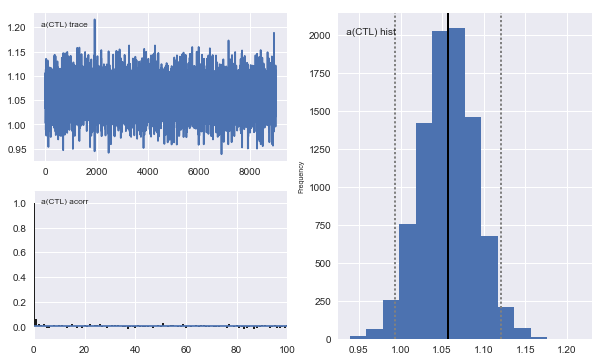

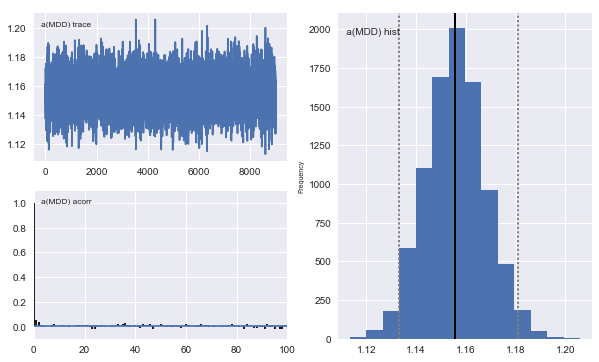

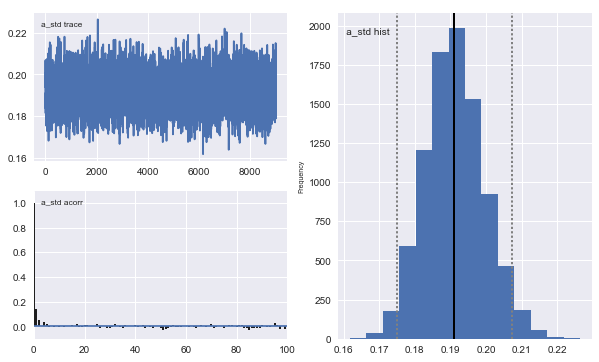

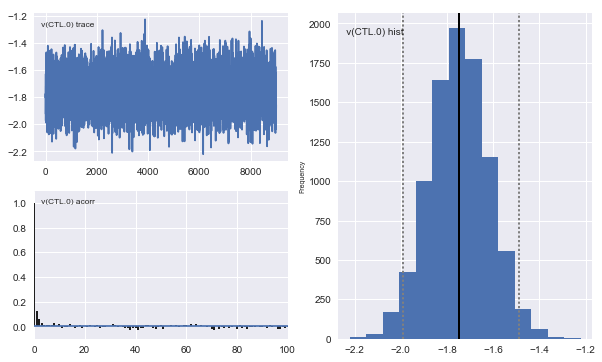

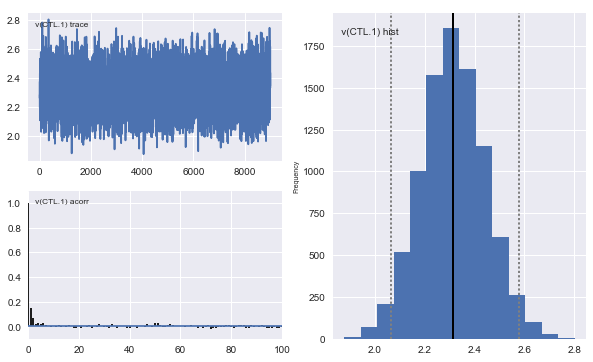

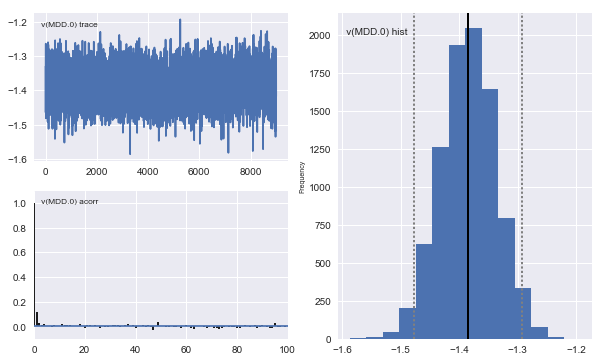

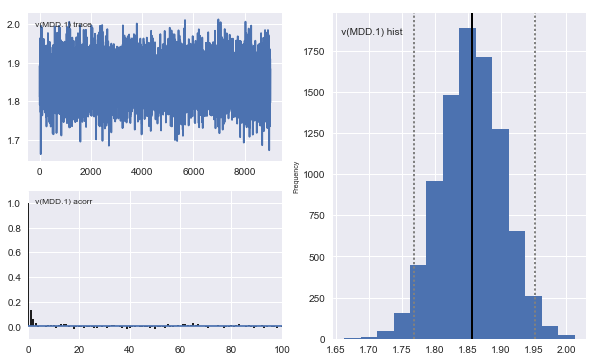

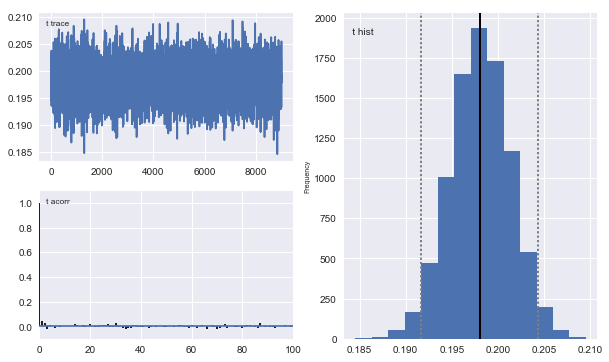

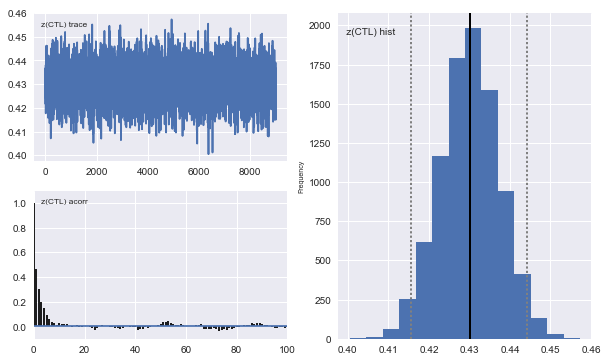

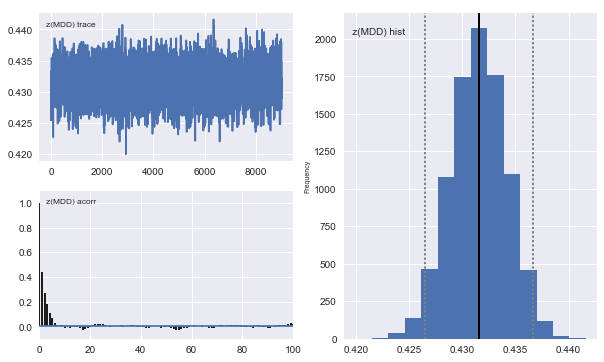

In [25]:
v_dep_on_stim.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

P_z(MDD > CON) =  0.573888888889
P_z(CON > MDD) =  0.426111111111


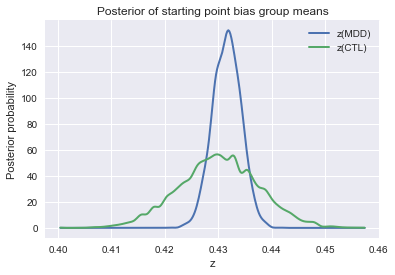

In [41]:
# This doesn't look awful but doesn't look right either, z should be > .05, representing a bias towards the rich stim
# (coded as the upper boundary)
z_MDD, z_CON = v_dep_on_stim.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.997555555556
P_a(CON > MDD) =  0.00244444444444


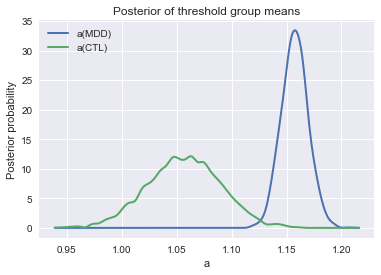

In [27]:
a_MDD, a_CON = v_dep_on_stim.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_v(MDD > CON) =  0.995666666667
P_v(CON > MDD) =  0.00433333333333


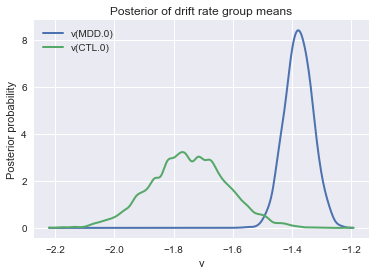

In [28]:
v_MDD, v_CON = v_dep_on_stim.nodes_db.node[['v(MDD.0)','v(CTL.0)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_v(MDD > CON) =  0.000111111111111
P_v(CON > MDD) =  0.999888888889


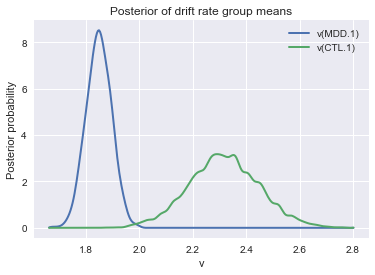

In [29]:
v_MDD, v_CON = v_dep_on_stim.nodes_db.node[['v(MDD.1)','v(CTL.1)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

Some links:  
https://groups.google.com/forum/#!searchin/hddm-users/bias%7Csort:relevance/hddm-users/la8Y-haT64E/DGsJYJTnj5QJ  
https://groups.google.com/forum/#!topic/hddm-users/H06IccKFB_g  (My question)

**Model 5**

This is the same as model 4, except a depends on stim here.

In [4]:
model_five = hddm.HDDMStimCoding(data, stim_col='stim', depends_on={'v': ['feasibility','stim'], 'a': ['feasibility','stim'], 'z': 'feasibility'}, include=('z'))
model_five.find_starting_values()
model_five.sample(30000, burn=2000)

Setting model to be non-informative
Adding z to includes.


KeyboardInterrupt: 

In [97]:
model_five.dic_info

{'DIC': -11871.695027848344,
 'deviance': -13386.653029063056,
 'pD': 1514.9580012147126}

In [ ]:
# a different way to check convergence
from kabuki.analyze import check_geweke
print check_geweke(model_five)

Plotting a(CTL.0)
Plotting a(CTL.1)
Plotting a(MDD.0)
Plotting a(MDD.1)
Plotting a_std
Plotting v(CTL.0)
Plotting v(CTL.1)
Plotting v(MDD.0)
Plotting v(MDD.1)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


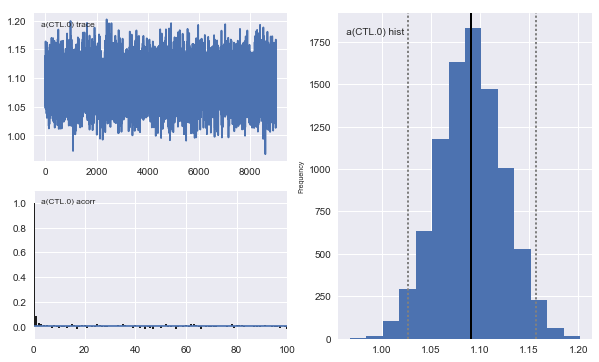

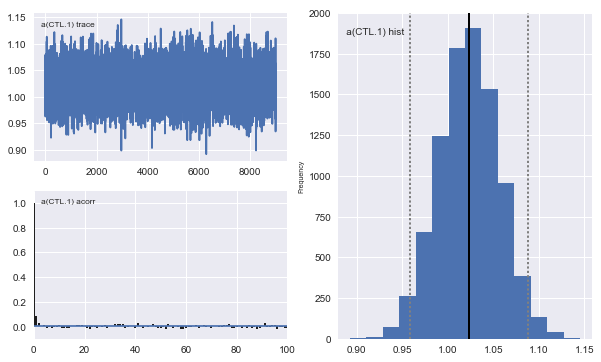

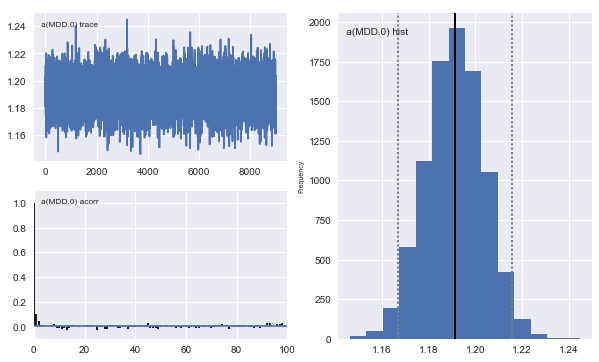

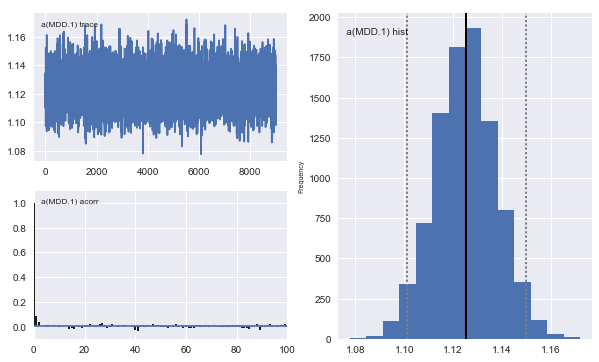

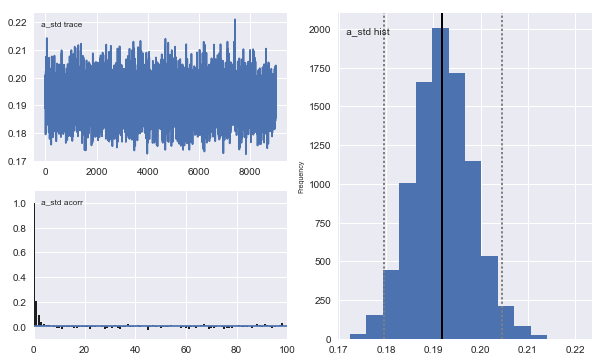

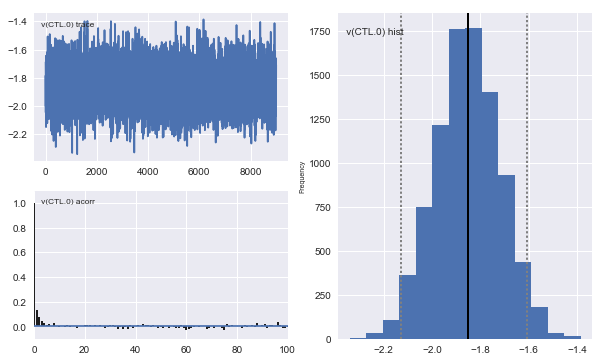

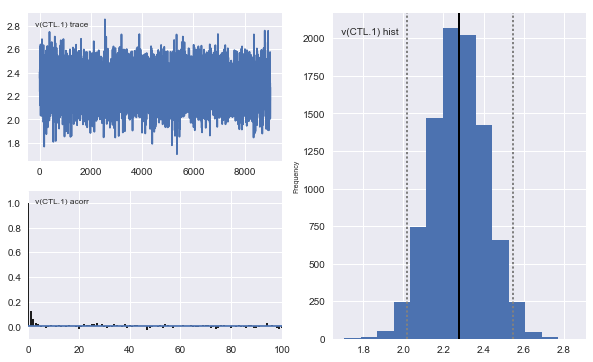

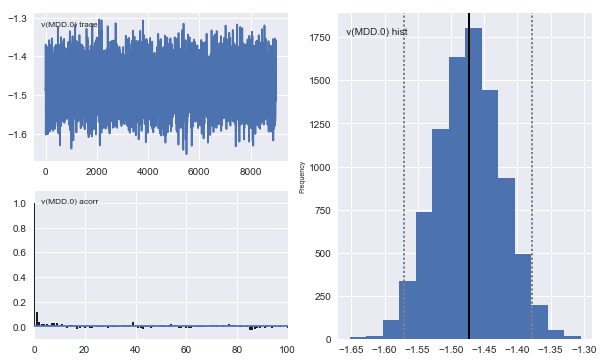

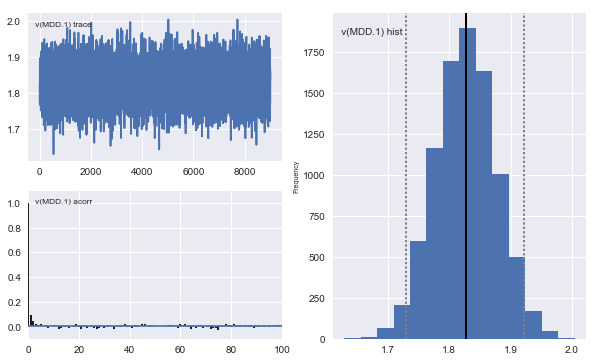

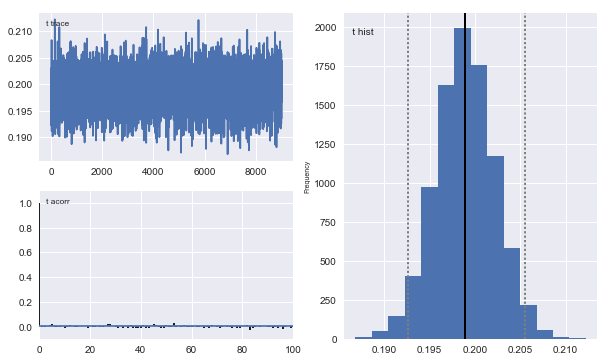

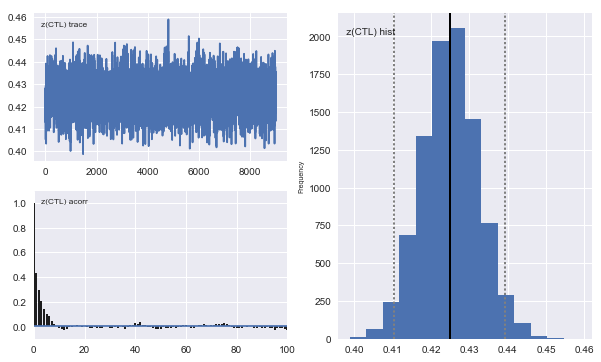

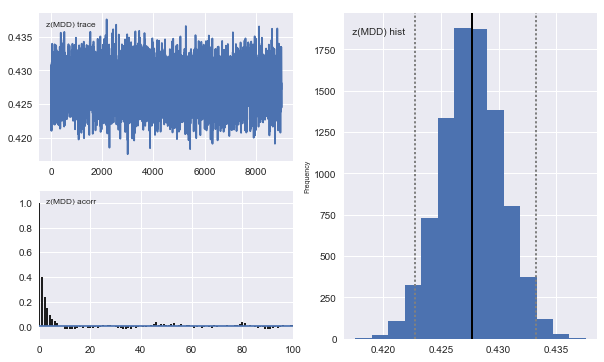

In [98]:
model_five.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

P_z(MDD > CON) =  0.641333333333
P_z(CON > MDD) =  0.358666666667


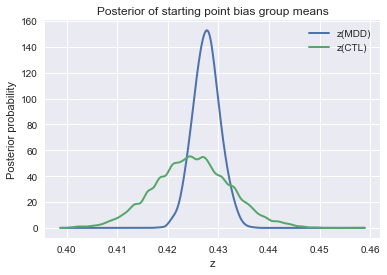

In [99]:
z_MDD, z_CON = model_five.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.996777777778
P_a(CON > MDD) =  0.00322222222222


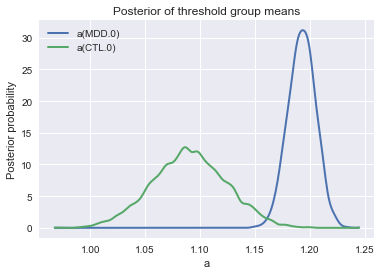

In [100]:
a_MDD, a_CON = model_five.nodes_db.node[['a(MDD.0)','a(CTL.0)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.997777777778
P_a(CON > MDD) =  0.00222222222222


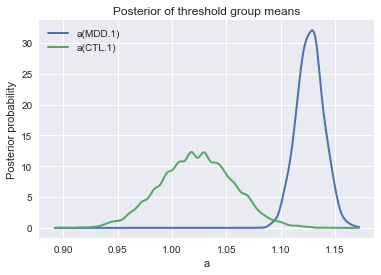

In [101]:
a_MDD, a_CON = model_five.nodes_db.node[['a(MDD.1)','a(CTL.1)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

This model allows us to compare thresholds for rich and lean stim in MDDs and CTLs (two cells below). Surprisingly, MDDs lower their threshold for rich stim more than CTLs.

P_a(MDD_lean > MDD_rich) =  0.999777777778
P_a(MDD_rich > MDD_lean) =  0.000222222222222


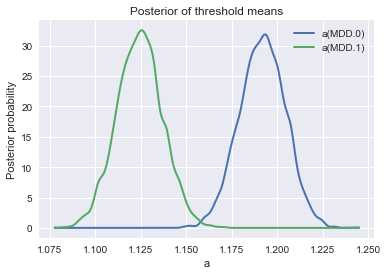

In [102]:
a_MDD_lean, a_MDD_rich = model_five.nodes_db.node[['a(MDD.0)','a(MDD.1)']]
hddm.analyze.plot_posterior_nodes([a_MDD_lean, a_MDD_rich])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(MDD_lean > MDD_rich) = ", (a_MDD_lean.trace() > a_MDD_rich.trace()).mean())
print ("P_a(MDD_rich > MDD_lean) = ", (a_MDD_rich.trace() > a_MDD_lean.trace()).mean())

P_a(CTL_lean > CTL_rich) =  0.923111111111
P_a(CTL_rich > CTL_lean) =  0.0768888888889


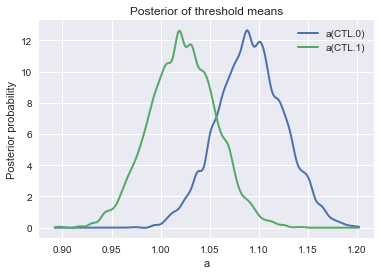

In [103]:
a_CTL_lean, a_CTL_rich = model_five.nodes_db.node[['a(CTL.0)','a(CTL.1)']]
hddm.analyze.plot_posterior_nodes([a_CTL_lean, a_CTL_rich])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(CTL_lean > CTL_rich) = ", (a_CTL_lean.trace() > a_CTL_rich.trace()).mean())
print ("P_a(CTL_rich > CTL_lean) = ", (a_CTL_rich.trace() > a_CTL_lean.trace()).mean())

P_v(MDD > CTL) =  0.995888888889
P_v(CTL > MDD) =  0.00411111111111


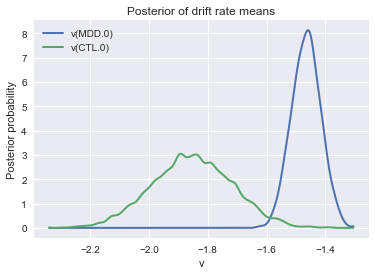

In [105]:
# comparing MDDs and CTLs on LEAN stim
v_MDD, v_CTL = model_five.nodes_db.node[['v(MDD.0)','v(CTL.0)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means for LEAN stim')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

P_v(MDD > CTL) =  0.00144444444444
P_v(CTL > MDD) =  0.998555555556


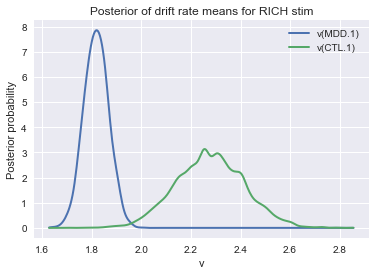

In [106]:
# comparing MDDs and CTLs on RICH stim
v_MDD, v_CTL = model_five.nodes_db.node[['v(MDD.1)','v(CTL.1)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means for RICH stim')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

**Model 6**

This is model 1 except that 'a' is depends on 'stim.' This gives a higher dic. If you look at the two 'a' figs they look the same, which makes sense. 

In [86]:
model_six = hddm.HDDMStimCoding(data, include='z', stim_col='stim', split_param='v', depends_on={'v': 'feasibility', 'a': ['feasibility','stim'], 'z': 'feasibility'})
model_six.find_starting_values()
model_six.sample(10000, burn=1000, dbname='embarc_stim_group_bias.db', db='pickle')

 [-----------------100%-----------------] 10001 of 10000 complete in 6488.1 sec

In [88]:
model_six.dic_info

{'DIC': -10519.987830937178,
 'deviance': -11816.416014868397,
 'pD': 1296.4281839312189}

Plotting a(CTL.0)
Plotting a(CTL.1)
Plotting a(MDD.0)
Plotting a(MDD.1)
Plotting a_std
Plotting v(CTL)
Plotting v(MDD)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


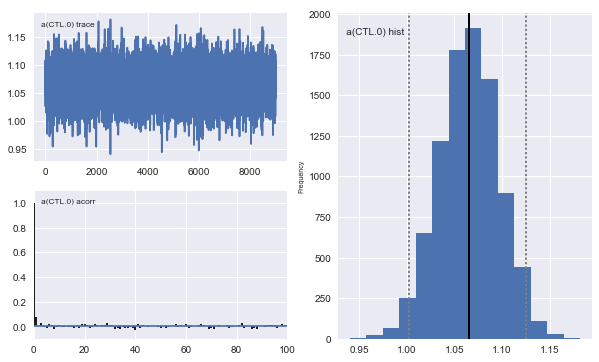

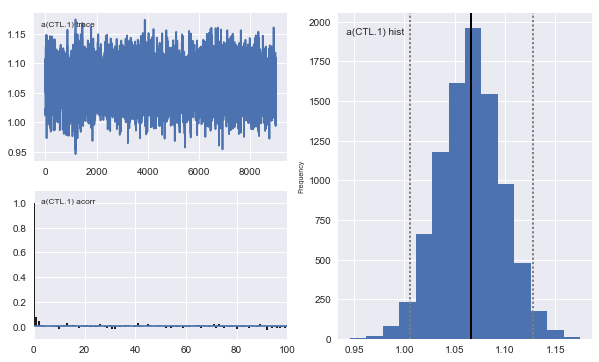

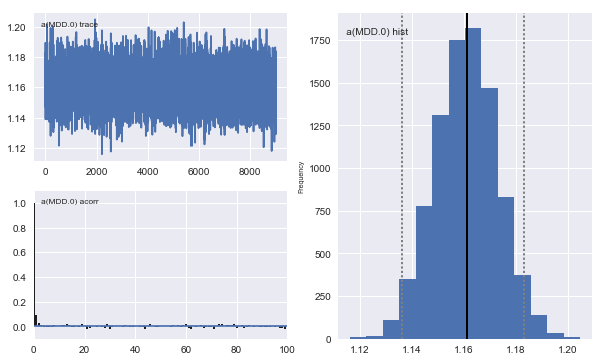

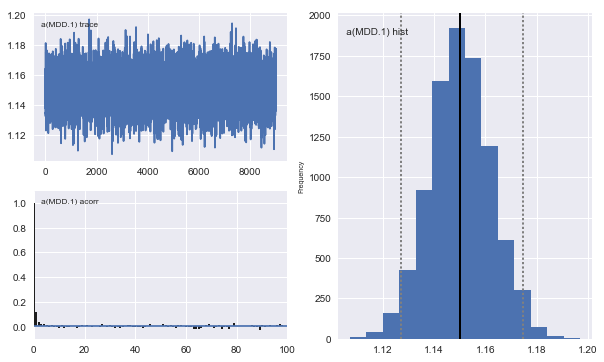

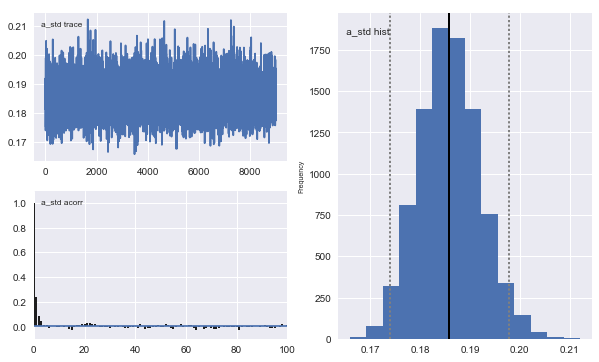

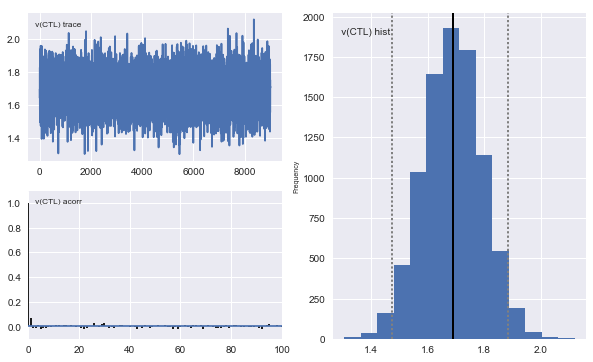

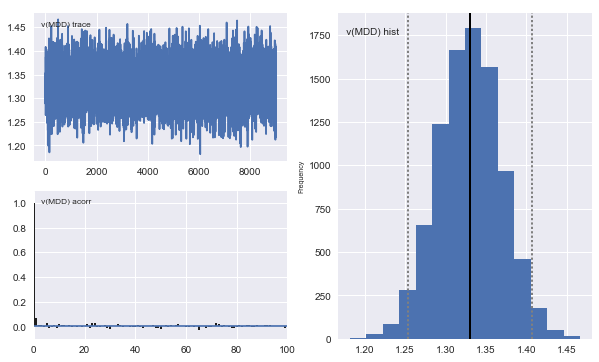

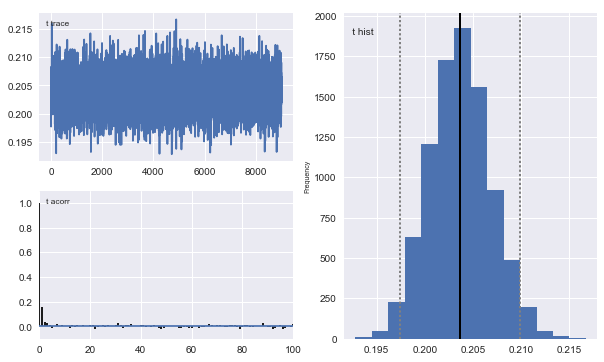

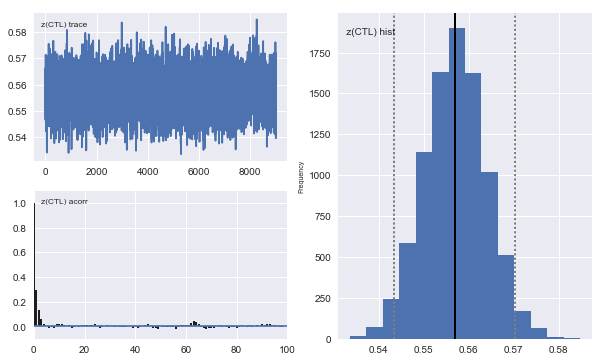

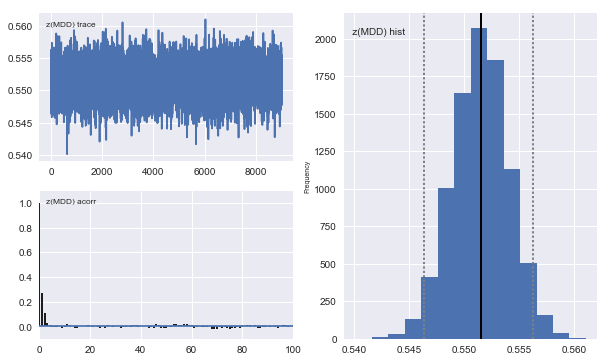

In [89]:
model_six.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

P_z(MDD > CON) =  0.222111111111
P_z(CON > MDD) =  0.777888888889


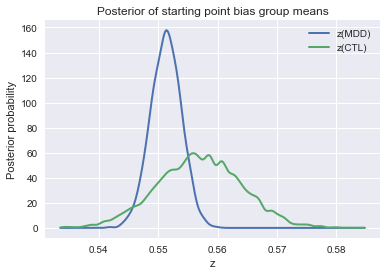

In [90]:
z_MDD, z_CON = model_six.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_a(MDD > CON) =  0.994444444444
P_a(CON > MDD) =  0.00555555555556


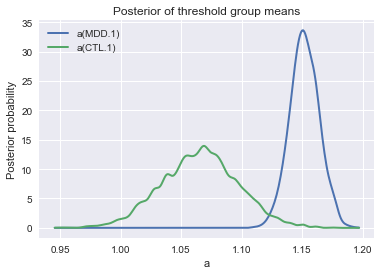

In [92]:
a_MDD, a_CON = model_six.nodes_db.node[['a(MDD.1)','a(CTL.1)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.998
P_a(CON > MDD) =  0.002


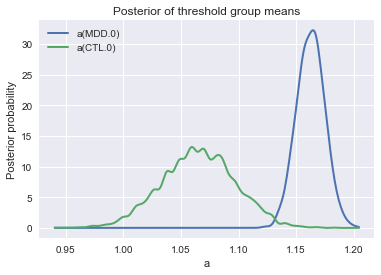

In [94]:
a_MDD, a_CON = model_six.nodes_db.node[['a(MDD.0)','a(CTL.0)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_v(MDD > CON) =  0.00111111111111
P_v(CON > MDD) =  0.998888888889


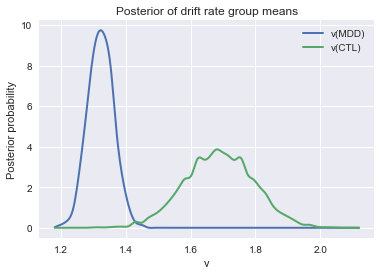

In [96]:
v_MDD, v_CON = model_six.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

## Posterior Predictive Checks  
http://ski.clps.brown.edu/hddm_docs/tutorial_post_pred.html  
  
Summary: No glaring problems emerged from any of the models (they all were 'credible' in the 95% range), but these do support that model 1 is the best. 

#### Model 1

In [30]:
ppc_data_m1 = hddm.utils.post_pred_gen(stim_coding_model)
ppc_data_m1.head()

 [-----------------100%-----------------] 591 of 588 complete in 4157.9 sec

rt  response
node                                      
wfpt(CTL.0).CU0009 0 0 -1.046766       0.0
                     1 -0.431566       0.0
                     2 -0.332066       0.0
                     3 -0.980966       0.0
                     4 -0.385166       0.0

Here the 'observed' column is our data and the 'mean' column is the simulated data. The rest of the columns are measures of how far the summary statistic of the data is away from the summary statistics of the simulated data. SEM = standard error from the mean, MSE = mean-squared error, credible = in the 95% credible interval

In [31]:
ppc_compare_m1 = hddm.utils.post_pred_stats(data, ppc_data_m1)
print (ppc_compare_m1)

          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.536574  0.536329  0.315731  5.963691e-08  0.099686     True   
mean_ub   0.447114  0.461323  0.127414  2.018962e-04  0.016436     True   
std_ub    0.211412  0.206058  0.097502  2.866759e-05  0.009535     True   
10q_ub    0.255000  0.276755  0.069903  4.732776e-04  0.005360     True   
30q_ub    0.329000  0.330745  0.084527  3.044233e-06  0.007148     True   
50q_ub    0.397000  0.398702  0.107922  2.896789e-06  0.011650     True   
70q_ub    0.487000  0.502519  0.148648  2.408360e-04  0.022337     True   
90q_ub    0.690000  0.720607  0.245202  9.368056e-04  0.061061     True   
mean_lb  -0.484861 -0.504793  0.143065  3.973076e-04  0.020865     True   
std_lb    0.203617  0.209979  0.103847  4.048051e-05  0.010825     True   
10q_lb    0.298000  0.308777  0.083171  1.161413e-04  0.007034     True   
30q_lb    0.376000  0.372

#### Model 2

In [32]:
ppc_data_m2 = hddm.utils.post_pred_gen(reg_model)
ppc_data_m2.head()

 [-----------------101%-----------------] 297 of 294 complete in 6761.6 sec

rt  response
node                                    
wfpt(CTL).CU0009 0 0 -0.504319       0.0
                   1  0.320092       1.0
                   2 -0.617970       0.0
                   3 -0.341456       0.0
                   4  0.363993       1.0

In [33]:
ppc_compare_m2 = hddm.utils.post_pred_stats(data, ppc_data_m2)
print (ppc_compare_m2)

          observed      mean       std           SEM       MSE credible  \
stat                                                                      
accuracy  0.536574  0.537252  0.066648  4.605686e-07  0.004442     True   
mean_ub   0.447114  0.446150  0.119978  9.287226e-07  0.014396     True   
std_ub    0.211412  0.156898  0.085491  2.971842e-03  0.010280     True   
10q_ub    0.255000  0.289390  0.070580  1.182682e-03  0.006164     True   
30q_ub    0.329000  0.354217  0.080034  6.358937e-04  0.007041     True   
50q_ub    0.397000  0.411421  0.095465  2.079782e-04  0.009322     True   
70q_ub    0.487000  0.484867  0.130612  4.548390e-06  0.017064     True   
90q_ub    0.690000  0.643434  0.223328  2.168388e-03  0.052044     True   
mean_lb  -0.484861 -0.490134  0.133936  2.780444e-05  0.017967     True   
std_lb    0.203617  0.162444  0.087911  1.695199e-03  0.009424     True   
10q_lb    0.298000  0.323366  0.076553  6.434121e-04  0.006504     True   
30q_lb    0.376000  0.394

#### Model 3

In [34]:
ppc_data_m3 = hddm.utils.post_pred_gen(stim_coding_model_nosplit)
ppc_data_m3.head()

 [-----------------100%-----------------] 591 of 588 complete in 4103.0 sec

rt  response
node                                      
wfpt(CTL.0).CU0009 0 0 -0.375944       0.0
                     1  0.661644       1.0
                     2 -0.632144       0.0
                     3  0.832444       1.0
                     4  1.435444       1.0

In [43]:
# While these are all 'credible,' they definitely don't look as good as the first two models. 

ppc_compare_m3 = hddm.utils.post_pred_stats(data, ppc_data_m3)
print (ppc_compare_m3)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.536574  0.540037  0.110057  0.000012  0.012125     True   
mean_ub   0.447114  0.499783  0.145276  0.002774  0.023879     True   
std_ub    0.211412  0.233659  0.098889  0.000495  0.010274     True   
10q_ub    0.255000  0.287991  0.077377  0.001088  0.007076     True   
30q_ub    0.329000  0.351388  0.097600  0.000501  0.010027     True   
50q_ub    0.397000  0.429943  0.124828  0.001085  0.016667     True   
70q_ub    0.487000  0.548446  0.168335  0.003776  0.032112     True   
90q_ub    0.690000  0.797605  0.267869  0.011579  0.083332     True   
mean_lb  -0.484861 -0.499671  0.146217  0.000219  0.021599     True   
std_lb    0.203617  0.232354  0.100479  0.000826  0.010922     True   
10q_lb    0.298000  0.288964  0.078205  0.000082  0.006198     True   
30q_lb    0.376000  0.352074  0.098607  0.000572  0.010296     True   
50q_lb

#### Model 4

In [44]:
ppc_data_m4 = hddm.utils.post_pred_gen(v_dep_on_stim)
ppc_data_m4.head()

 [-----------------100%-----------------] 591 of 588 complete in 4094.2 sec

rt  response
node                                      
wfpt(CTL.0).CU0009 0 0 -0.307379       0.0
                     1 -0.529279       0.0
                     2  0.423879       1.0
                     3 -0.426979       0.0
                     4 -0.981679       0.0

In [45]:
ppc_compare_m4 = hddm.utils.post_pred_stats(data, ppc_data_m4)
print (ppc_compare_m4)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.536574  0.538802  0.312850  0.000005  0.097880     True   
mean_ub   0.447114  0.459666  0.130137  0.000158  0.017093     True   
std_ub    0.211412  0.194019  0.095858  0.000303  0.009491     True   
10q_ub    0.255000  0.281353  0.070756  0.000694  0.005701     True   
30q_ub    0.329000  0.336970  0.087359  0.000064  0.007695     True   
50q_ub    0.397000  0.403516  0.111546  0.000042  0.012485     True   
70q_ub    0.487000  0.501824  0.151826  0.000220  0.023271     True   
90q_ub    0.690000  0.703930  0.245229  0.000194  0.060331     True   
mean_lb  -0.484861 -0.461221  0.137371  0.000559  0.019430     True   
std_lb    0.203617  0.191302  0.100640  0.000152  0.010280     True   
10q_lb    0.298000  0.284776  0.073518  0.000175  0.005580     True   
30q_lb    0.376000  0.340463  0.091626  0.001263  0.009658     True   
50q_lb

## Assuming we're sticking with model 1, do we see anything with starting point bias over time?

Collapsing accross groups, do we see a difference in z between blocks 1 and 2?  
  
Yes, starting point bias is greater in block 2 than block 1. Drift rate and threshold are the same between blocks (though slight trend for more narrow threshold, might reflect better confidence as the task progresses)

In [69]:
block_bias_model = hddm.HDDMStimCoding(data, include='z', stim_col='stim', split_param='v', depends_on={'v': 'block', 'a': 'block', 'z': 'block'})
block_bias_model.find_starting_values()
block_bias_model.sample(5000, burn=500, dbname='embarc_stim_block_bias.db', db='pickle')


 [-----------------100%-----------------] 5001 of 5000 complete in 5252.0 sec

P_z(block 1 > block 2) =  0.0
P_z(block 2 > block 1) =  1.0


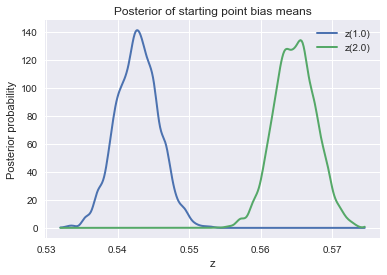

In [74]:
z_block1, z_block2 = block_bias_model.nodes_db.node[['z(1.0)','z(2.0)']]
hddm.analyze.plot_posterior_nodes([z_block1, z_block2])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias means')

print ("P_z(block 1 > block 2) = ", (z_block1.trace() > z_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (z_block2.trace() > z_block1.trace()).mean())

P_z(block 1 > block 2) =  0.676222222222
P_z(block 2 > block 1) =  0.323777777778


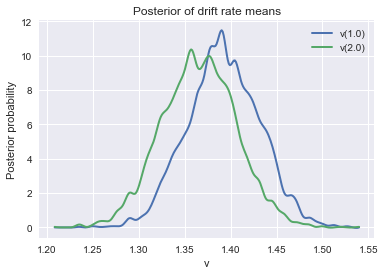

In [75]:
v_block1, v_block2 = block_bias_model.nodes_db.node[['v(1.0)','v(2.0)']]
hddm.analyze.plot_posterior_nodes([v_block1, v_block2])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_z(block 1 > block 2) = ", (v_block1.trace() > v_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (v_block2.trace() > v_block1.trace()).mean())

P_z(block 1 > block 2) =  0.921555555556
P_z(block 2 > block 1) =  0.0784444444444


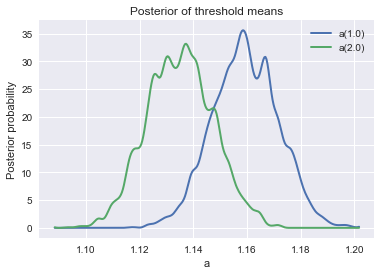

In [78]:
a_block1, a_block2 = block_bias_model.nodes_db.node[['a(1.0)','a(2.0)']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_z(block 1 > block 2) = ", (a_block1.trace() > a_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (a_block2.trace() > a_block1.trace()).mean())

In just the MDDs, do we see a difference in z between blocks 1 and 2?  
Yep

In [79]:
mdd_data = data[data.feasibility == 'MDD']
block_bias_mdd_model = hddm.HDDMStimCoding(mdd_data, include='z', stim_col='stim', split_param='v', depends_on={'z': 'block'})
block_bias_mdd_model.find_starting_values()
block_bias_mdd_model.sample(1000, burn=100, dbname='embarc_stim_block_bias_mdd.db', db='pickle')

 [-----------------100%-----------------] 1001 of 1000 complete in 808.7 sec

P_z(block 1 > block 2) =  0.0
P_z(block 2 > block 1) =  1.0


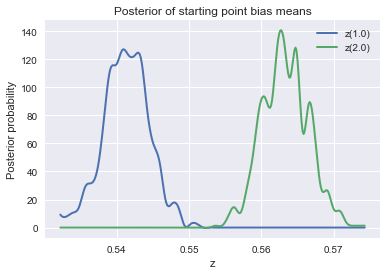

In [80]:
z_block1, z_block2 = block_bias_mdd_model.nodes_db.node[['z(1.0)','z(2.0)']]
hddm.analyze.plot_posterior_nodes([z_block1, z_block2])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias means')

print ("P_z(block 1 > block 2) = ", (z_block1.trace() > z_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (z_block2.trace() > z_block1.trace()).mean())

In just the CTLs, do we see a difference in z between blocks 1 and 2?  
Yep, and the means look the same as mdds

In [81]:
ctl_data = data[data.feasibility == 'CTL']
block_bias_ctl_model = hddm.HDDMStimCoding(mdd_data, include='z', stim_col='stim', split_param='v', depends_on={'z': 'block'})
block_bias_ctl_model.find_starting_values()
block_bias_ctl_model.sample(1000, burn=100, dbname='embarc_stim_block_bias_ctl.db', db='pickle')

 [-----------------100%-----------------] 1001 of 1000 complete in 797.3 sec

P_z(block 1 > block 2) =  0.0
P_z(block 2 > block 1) =  1.0


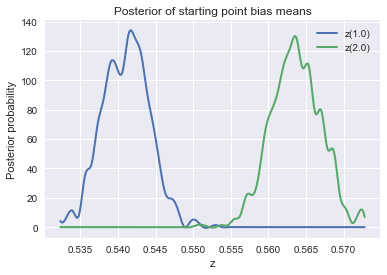

In [82]:
z_block1, z_block2 = block_bias_ctl_model.nodes_db.node[['z(1.0)','z(2.0)']]
hddm.analyze.plot_posterior_nodes([z_block1, z_block2])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias means')

print ("P_z(block 1 > block 2) = ", (z_block1.trace() > z_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (z_block2.trace() > z_block1.trace()).mean())

## Since we are going with model 5...

**Models on just blocks 1 & 2 comparing groups**

In [5]:
block1_data = data[data.block == 1]
block1_data.head()

,Unnamed: 0,subj_idx,site_x,subject_x,date,bias,rich_stim,lean_stim,rich_key,lean_key,...,rt,response,correct,did_reward,reward_due,rich_due,lean_due,outlier,feasibility,block
0,0,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.704,0,0,0,0,0,0,0,CTL,1.0
1,1,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.414,0,1,1,1,0,0,0,CTL,1.0
2,2,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.456,1,1,1,1,0,0,0,CTL,1.0
3,3,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.416,0,1,0,0,0,0,0,CTL,1.0
4,4,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.490,0,0,0,0,0,0,0,CTL,1.0


In [6]:
block2_data = data[data.block == 2]
block2_data.head()

,Unnamed: 0,subj_idx,site_x,subject_x,date,bias,rich_stim,lean_stim,rich_key,lean_key,...,rt,response,correct,did_reward,reward_due,rich_due,lean_due,outlier,feasibility,block
99,99,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.363,0,1,0,0,0,0,0,CTL,2.0
100,100,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.568,1,1,1,1,0,0,0,CTL,2.0
101,101,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.395,1,1,1,1,0,0,0,CTL,2.0
102,102,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.375,0,0,0,1,1,0,0,CTL,2.0
103,103,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.387,0,1,0,0,1,0,0,CTL,2.0


In [7]:
# setting up the block 1 model
block1_model = hddm.HDDMStimCoding(block1_data, stim_col='stim', depends_on={'v': ['feasibility','stim'], 'a': ['feasibility','stim'], 'z': 'feasibility'}, include=('z'))
block1_model.find_starting_values()
block1_model.sample(10000, burn=1000)

Setting model to be non-informative
Adding z to includes.
 [-----------------100%-----------------] 10001 of 10000 complete in 17344.5 sec

Plotting a(CTL.0)
Plotting a(CTL.1)
Plotting a(MDD.0)
Plotting a(MDD.1)
Plotting a_std
Plotting v(CTL.0)
Plotting v(CTL.1)
Plotting v(MDD.0)
Plotting v(MDD.1)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


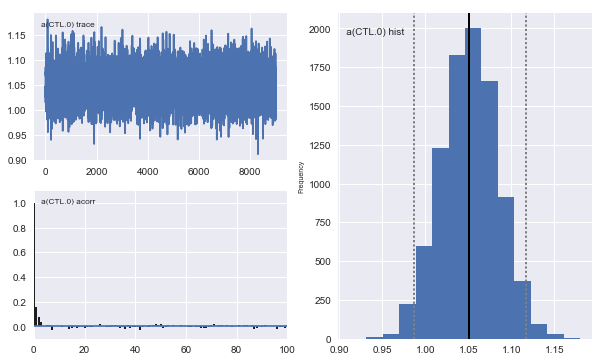

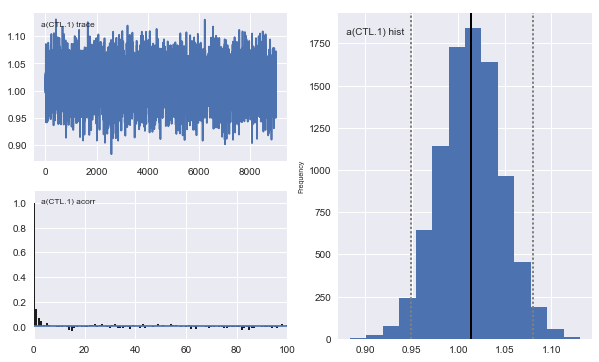

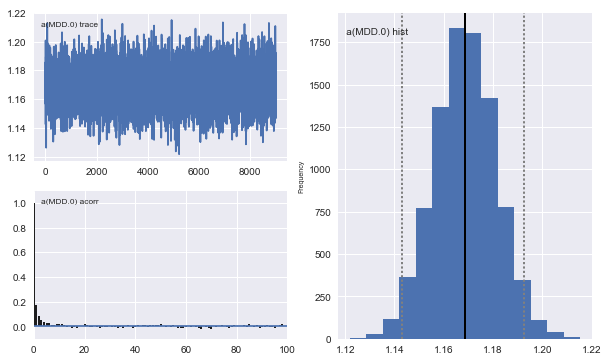

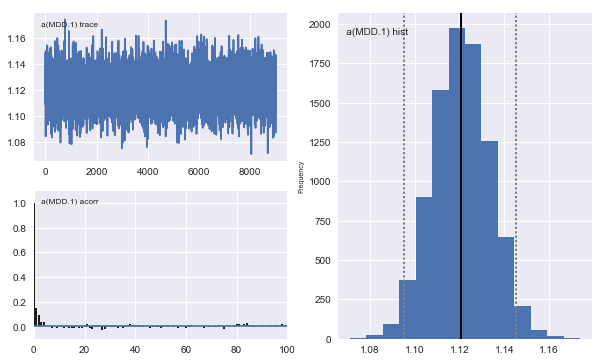

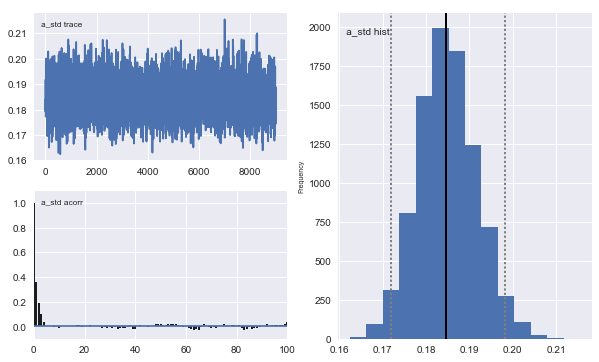

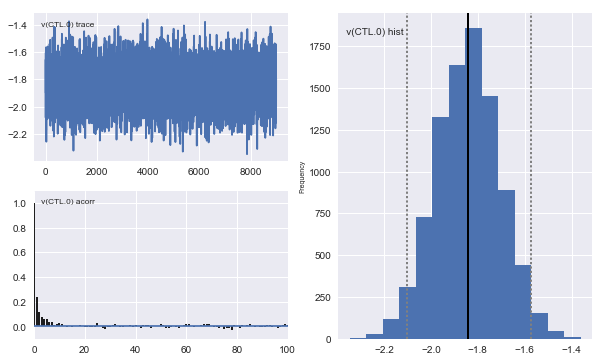

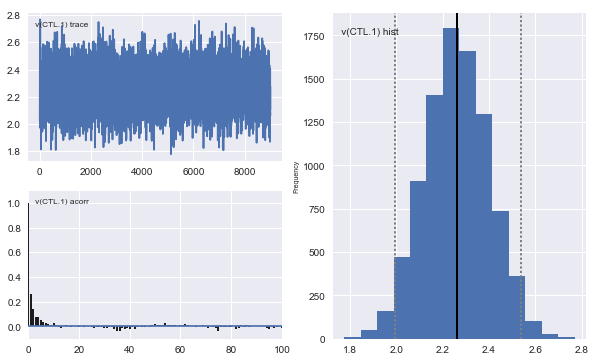

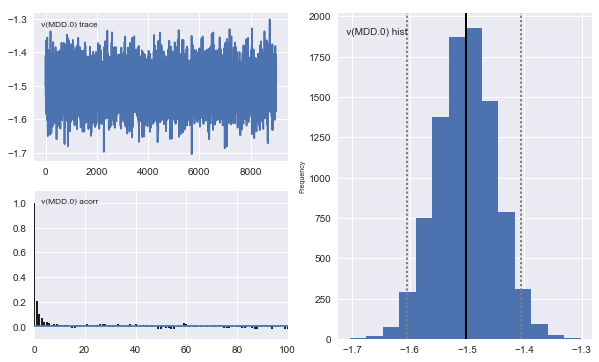

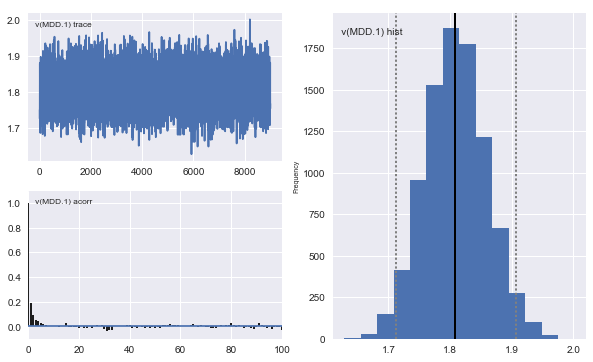

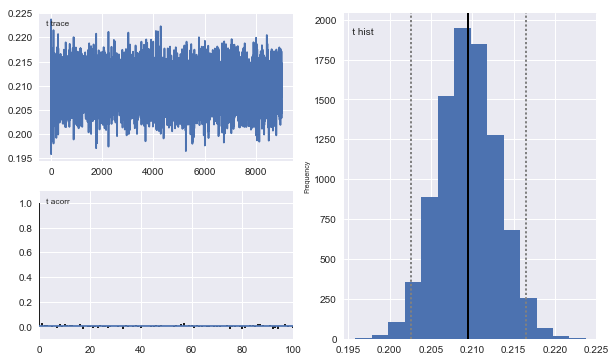

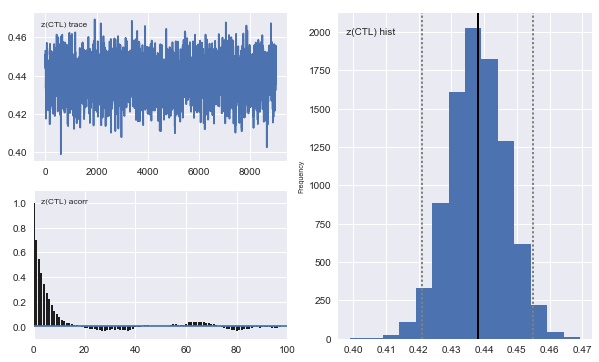

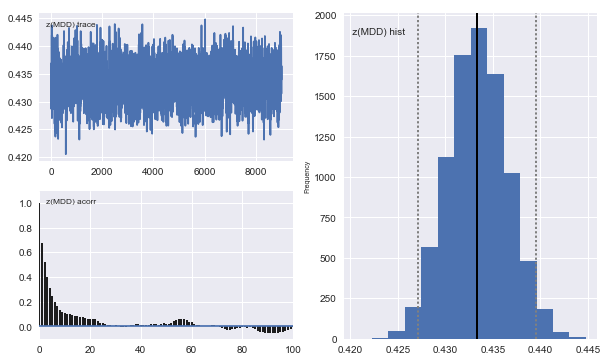

In [8]:
# checking convergence
block1_model.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

In [19]:
# setting up the block 2 model
block2_model = hddm.HDDMStimCoding(block2_data, stim_col='stim', depends_on={'v': ['feasibility','stim'], 'a': ['feasibility','stim'], 'z': 'feasibility'}, include=('z'))
block2_model.find_starting_values()
block2_model.sample(10000, burn=1000)

Setting model to be non-informative
Adding z to includes.
 [-----------------100%-----------------] 10001 of 10000 complete in 16941.5 sec

Plotting a(CTL.0)
Plotting a(CTL.1)
Plotting a(MDD.0)
Plotting a(MDD.1)
Plotting a_std
Plotting v(CTL.0)
Plotting v(CTL.1)
Plotting v(MDD.0)
Plotting v(MDD.1)
Plotting t
Plotting z(CTL)
Plotting z(MDD)


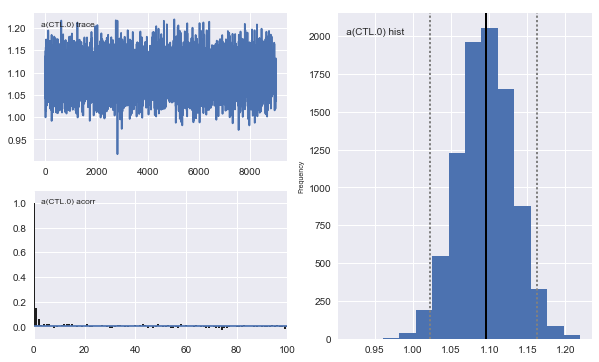

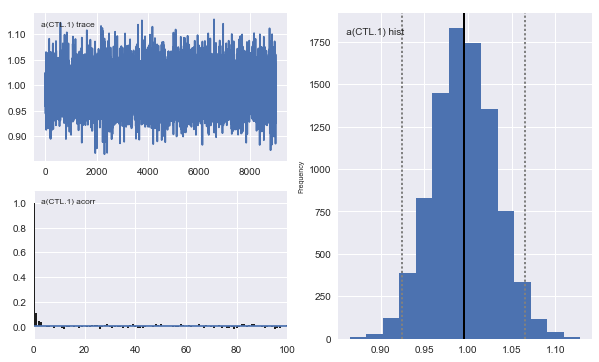

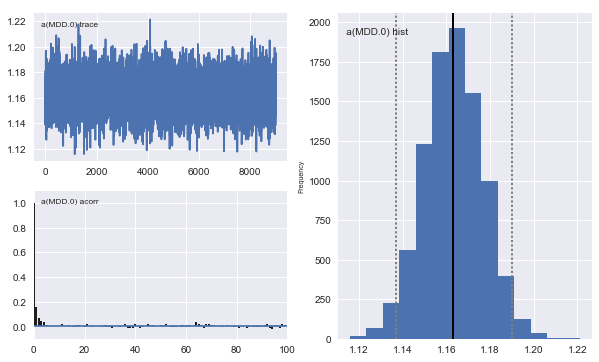

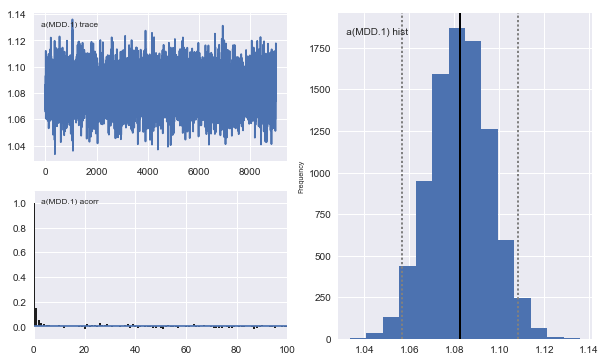

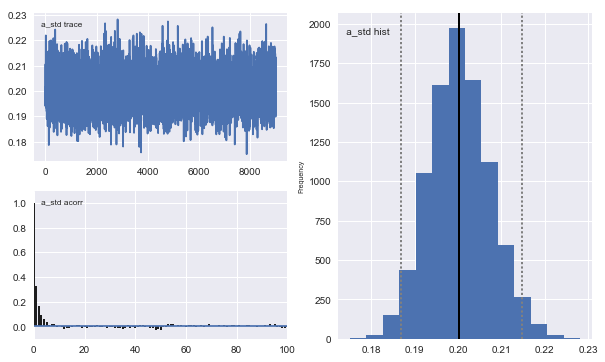

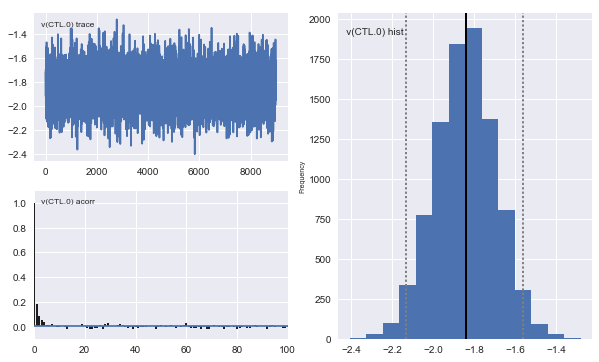

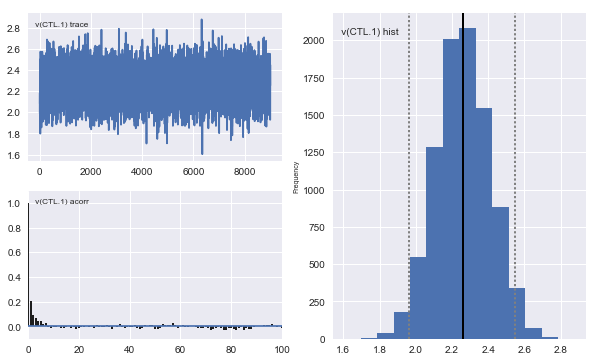

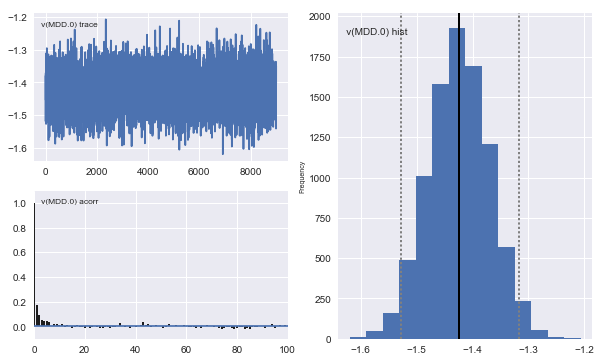

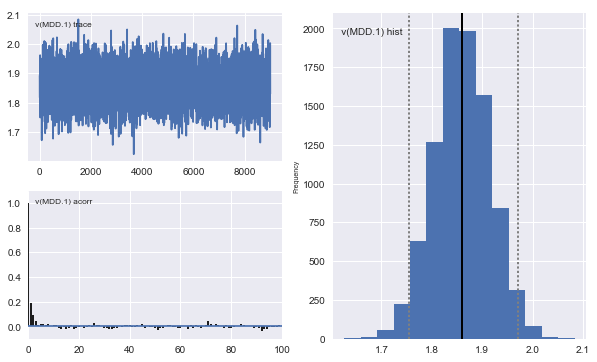

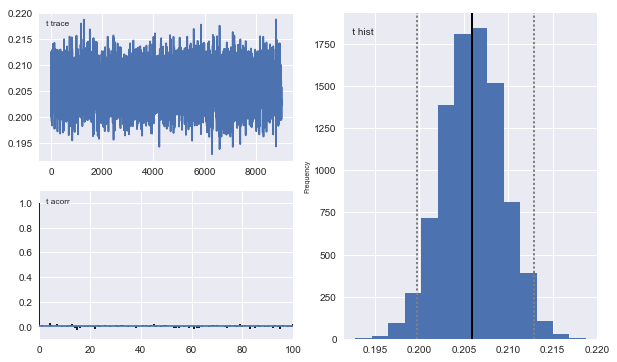

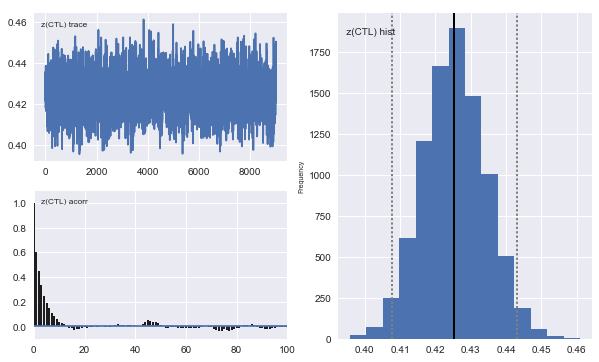

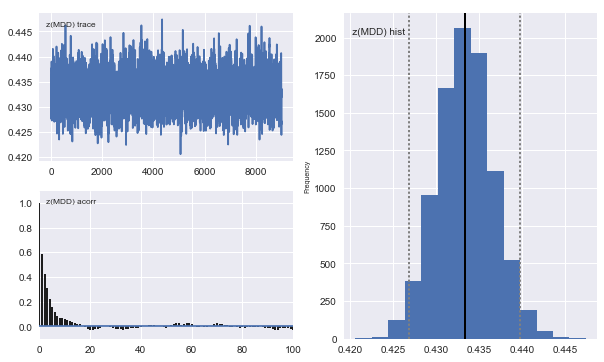

In [20]:
# checking convergence
block2_model.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

In block 1, do MDDs and CTLs differ on drift rate for lean stim?  
Yes

P_z(MDD > CTL) =  0.989888888889
P_z(CTL > MDD) =  0.0101111111111


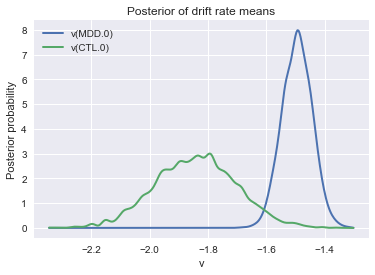

In [14]:
v_MDD, v_CTL = block1_model.nodes_db.node[['v(MDD.0)','v(CTL.0)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_z(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_z(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

rich stim?  
Yes

P_z(MDD > CTL) =  0.000444444444444
P_z(CTL > MDD) =  0.999555555556


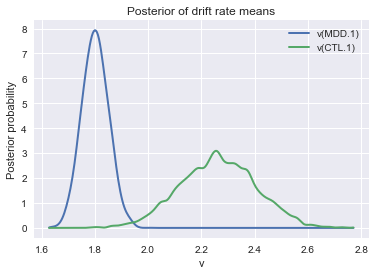

In [15]:
v_MDD, v_CTL = block1_model.nodes_db.node[['v(MDD.1)','v(CTL.1)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_z(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_z(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

Is this the same in block 2?

In [ ]:
#run me
v_MDD, v_CTL = block2_model.nodes_db.node[['v(MDD.0)','v(CTL.0)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_z(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_z(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

In [ ]:
#run me
v_MDD, v_CTL = block2_model.nodes_db.node[['v(MDD.1)','v(CTL.1)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_z(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_z(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

In block 1, do MDDs and CTLs differ in threshold for lean stim?  
Yes

P_a(MDD > CTL) =  0.999444444444
P_a(CTL > MDD) =  0.000555555555556


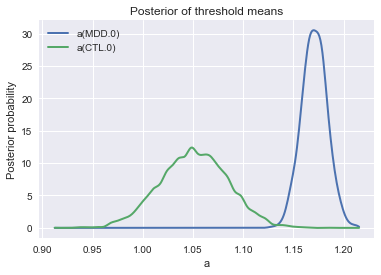

In [16]:
a_MDD, a_CTL = block1_model.nodes_db.node[['a(MDD.0)','a(CTL.0)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

Rich stim?  
yes

P_a(MDD > CTL) =  0.999111111111
P_a(CTL > MDD) =  0.000888888888889


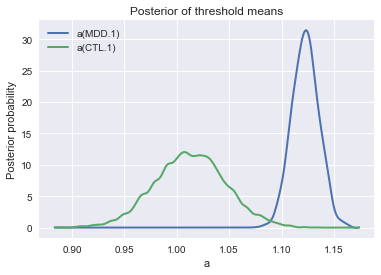

In [17]:
a_MDD, a_CTL = block1_model.nodes_db.node[['a(MDD.1)','a(CTL.1)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

Is this the same in block 2?

In [ ]:
#run me
a_MDD, a_CTL = block2_model.nodes_db.node[['a(MDD.0)','a(CTL.0)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

In [ ]:
#run me
a_MDD, a_CTL = block2_model.nodes_db.node[['a(MDD.1)','a(CTL.1)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

In block 1, do MDDs and CTLs differ in starting point?  
No

P_z(MDD > CTL) =  0.303111111111
P_z(CTL > MDD) =  0.696888888889


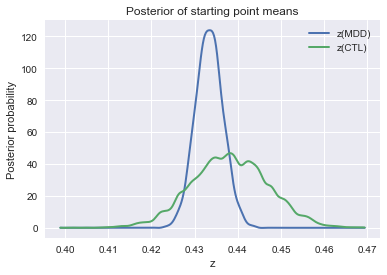

In [18]:
z_MDD, z_CTL = block1_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CTL])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point means')

print ("P_z(MDD > CTL) = ", (z_MDD.trace() > z_CTL.trace()).mean())
print ("P_z(CTL > MDD) = ", (z_CTL.trace() > z_MDD.trace()).mean())

Is this the same in block 2?

In [ ]:
#run me
z_MDD, z_CTL = block2_model.nodes_db.node[['z(MDD)','z(CTL)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CTL])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point means')

print ("P_z(MDD > CTL) = ", (z_MDD.trace() > z_CTL.trace()).mean())
print ("P_z(CTL > MDD) = ", (z_CTL.trace() > z_MDD.trace()).mean())

Summary:

**Models on just MDDs and CTLs comparing blocks**

In [21]:
ctl_data = data[data.feasibility == 'CTL']
ctl_data.head()

,Unnamed: 0,subj_idx,site_x,subject_x,date,bias,rich_stim,lean_stim,rich_key,lean_key,...,rt,response,correct,did_reward,reward_due,rich_due,lean_due,outlier,feasibility,block
0,0,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.704,0,0,0,0,0,0,0,CTL,1.0
1,1,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.414,0,1,1,1,0,0,0,CTL,1.0
2,2,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.456,1,1,1,1,0,0,0,CTL,1.0
3,3,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.416,0,1,0,0,0,0,0,CTL,1.0
4,4,MG0006,MG,6,4/24/2012,short,short,long,c,m,...,0.490,0,0,0,0,0,0,0,CTL,1.0


In [22]:
mdd_data = data[data.feasibility == 'MDD']
mdd_data.head()

,Unnamed: 0,subj_idx,site_x,subject_x,date,bias,rich_stim,lean_stim,rich_key,lean_key,...,rt,response,correct,did_reward,reward_due,rich_due,lean_due,outlier,feasibility,block
1195,1195,MG0032,MG,32,1/17/2013,short,short,long,c,m,...,0.333,0,0,0,0,0,0,0,MDD,1.0
1196,1196,MG0032,MG,32,1/17/2013,short,short,long,c,m,...,0.314,0,1,1,1,0,0,0,MDD,1.0
1197,1197,MG0032,MG,32,1/17/2013,short,short,long,c,m,...,0.344,0,0,0,1,1,0,0,MDD,1.0
1198,1198,MG0032,MG,32,1/17/2013,short,short,long,c,m,...,0.229,0,1,0,0,1,0,0,MDD,1.0
1199,1199,MG0032,MG,32,1/17/2013,short,short,long,c,m,...,0.263,1,1,1,1,0,0,0,MDD,1.0


In [ ]:
# setting up control model
ctl_model = hddm.HDDMStimCoding(ctl_data, stim_col='stim', depends_on={'v': ['block','stim'], 'a': ['block','stim'], 'z': 'block'}, include=('z'))
ctl_model.find_starting_values()
ctl_model.sample(10000, burn=1000)

In [ ]:
# checking convergence
ctl_model.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

In [ ]:
# setting up mdd model
mdd_model = hddm.HDDMStimCoding(mdd_data, stim_col='stim', depends_on={'v': ['block','stim'], 'a': ['block','stim'], 'z': 'block'}, include=('z'))
mdd_model.find_starting_values()
mdd_model.sample(10000, burn=1000)

Setting model to be non-informative
Adding z to includes.
 [--                6%                  ] 602 of 10000 complete in 5912.0 sec

In [ ]:
# checking convergence
mdd_model.plot_posteriors(['a', 't', 'v', 'a_std', 'z'])

Do MDDs differ in drift rate from block 1 to 2?

In [ ]:
#run me
v_block1, v_block2 = mdd_model.nodes_db.node[['v(1.0)','v(2.0)']]
hddm.analyze.plot_posterior_nodes([v_block1, v_block2])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_v(block 1 > block 2) = ", (v_block1.trace() > v_block2.trace()).mean())
print ("P_v(block 2 > block 1) = ", (v_block2.trace() > v_block1.trace()).mean())

Is this the same for controls?

In [ ]:
#run me
v_block1, v_block2 = ctl_model.nodes_db.node[['v(1.0)','v(2.0)']]
hddm.analyze.plot_posterior_nodes([v_block1, v_block2])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate means')

print ("P_v(block 1 > block 2) = ", (v_block1.trace() > v_block2.trace()).mean())
print ("P_v(block 2 > block 1) = ", (v_block2.trace() > v_block1.trace()).mean())

Do MDDs differ in threshold from block 1 to 2?

In [ ]:
#run me
a_block1, a_block2 = mdd_model.nodes_db.node[['a(1.0)','a(2.0)']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(block 1 > block 2) = ", (a_block1.trace() > a_block2.trace()).mean())
print ("P_a(block 2 > block 1) = ", (a_block2.trace() > a_block1.trace()).mean())

Is this the same for controls?

In [ ]:
#run me
a_block1, a_block2 = ctl_model.nodes_db.node[['a(1.0)','a(2.0)']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold means')

print ("P_a(block 1 > block 2) = ", (a_block1.trace() > a_block2.trace()).mean())
print ("P_a(block 2 > block 1) = ", (a_block2.trace() > a_block1.trace()).mean())

Do MDDs differ in starting point bias from block 1 to 2?

In [ ]:
#run me
z_block1, z_block2 = mdd_model.nodes_db.node[['z(1.0)','z(2.0)']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point means')

print ("P_z(block 1 > block 2) = ", (z_block1.trace() > z_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (z_block2.trace() > z_block1.trace()).mean())

Is this the same for controls?

In [ ]:
#run me
z_block1, z_block2 = ctl_model.nodes_db.node[['z(1.0)','z(2.0)']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point means')

print ("P_z(block 1 > block 2) = ", (z_block1.trace() > z_block2.trace()).mean())
print ("P_z(block 2 > block 1) = ", (z_block2.trace() > z_block1.trace()).mean())